In [1]:
import os
from dose_reponse_fit import dose_response_fit, ModelPredictions, survival_to_stress, StandardSettings
# from plotting import plot_complete
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_formats import read_data
from plotting import plot_fit_prediction
from stress_survival_conversion import stress_to_survival, survival_to_stress
from sklearn.metrics import r2_score

In [2]:
dfs = []

for path in os.listdir("data"):
    
    data = read_data(f"data/{path}")
    
    meta = data.meta
    res : ModelPredictions = dose_response_fit(data.main_series, StandardSettings(beta_q=3.2, beta_p=3.2, param_d_norm=True, survival_max= meta.max_survival))
    
    title = f"{meta.chemical} - {meta.organism}"
    
    dfs.append({"title" : path[:-4], "chemical":meta.chemical, "organism":meta.organism, "model": res})

df = pd.DataFrame(dfs)
df.head()    

,title,chemical,organism,model
0,ayesha_chlorantran_2022_agriculture.,Chlrorantraniliprole,Gammarus pulex,ModelPredictions(concentration_curve=array([1....
1,naeem_Esfenvalerate_2019.,Esfenvalerate,Daphnia magna,ModelPredictions(concentration_curve=array([1....
2,ayesha-cloth_Clothianidin_2024_agricultural_pr...,Clothianidin,Gammarus pulex,ModelPredictions(concentration_curve=array([1....
3,ayesha_chlorantran_2022_reference.,Chlrorantraniliprole,Gammarus pulex,ModelPredictions(concentration_curve=array([1....
4,naeem_Esfenvalerate_2024.,Esfenvalerate,Daphnia magna,ModelPredictions(concentration_curve=array([1....


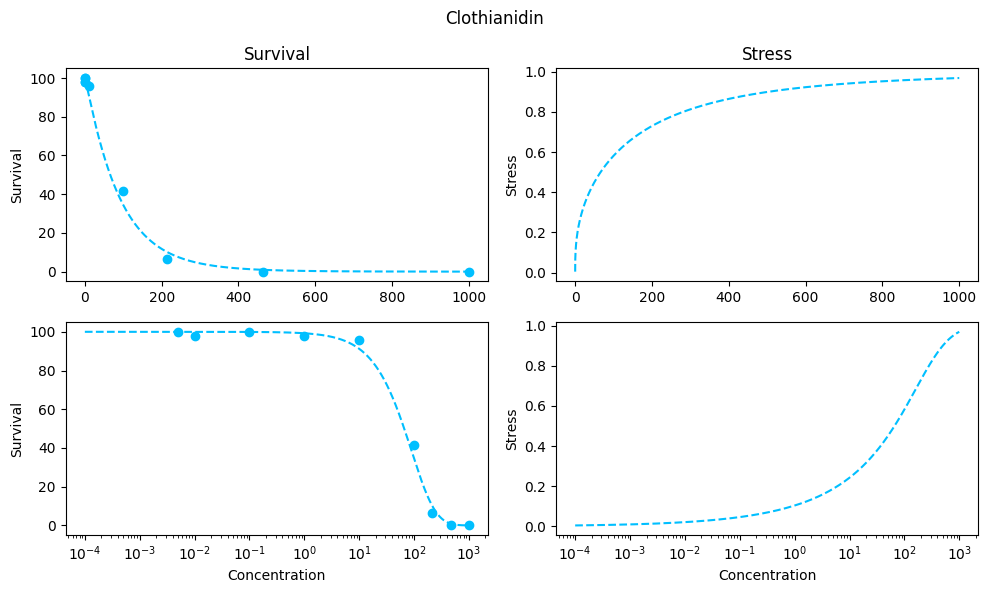

In [3]:
row = df.sample(1, random_state=4).iloc[0]
fig = plot_fit_prediction(row.model, row.chemical)


$$\text{stress} = \text{Beta}^{-1}(1 - \text{survival}, p, q)$$

$$\text{survival} = 1 - \text{Beta}(\text{stress}, p, q)$$


$$\text{stress} = \text{Beta}^{-1}(1 - \text{survival }/ c_0, p, q)$$

$$\text{survival} = (1 - \text{Beta}(\text{stress}, p, q)) * c_0$$




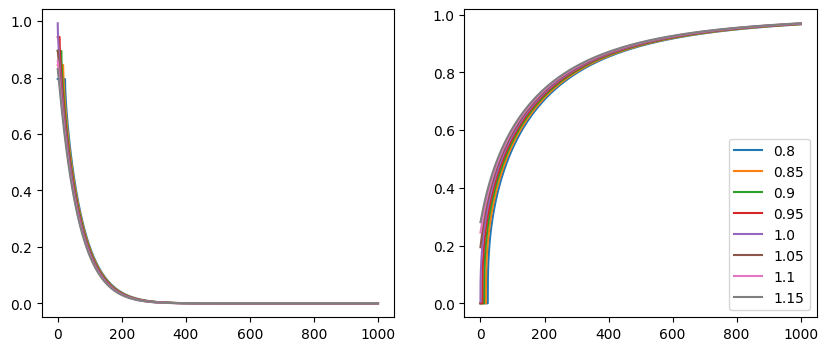

In [4]:
temps = np.arange(0.8,1.2,0.05)
temps = np.round(temps, 2)

model : ModelPredictions = row.model

fig, ax = plt.subplots(1,2, figsize = (10,4))

for temp in temps:
    
    normed = model.survival_curve / model.cfg.survival_max / temp
    
    stress = survival_to_stress(normed)

    back = stress_to_survival(stress+ 0.1) * temp
    
    ax[0].plot(model.concentration_curve, back, label = temp)    
    ax[1].plot(model.concentration_curve, stress, label = temp)    

ax[1].legend()

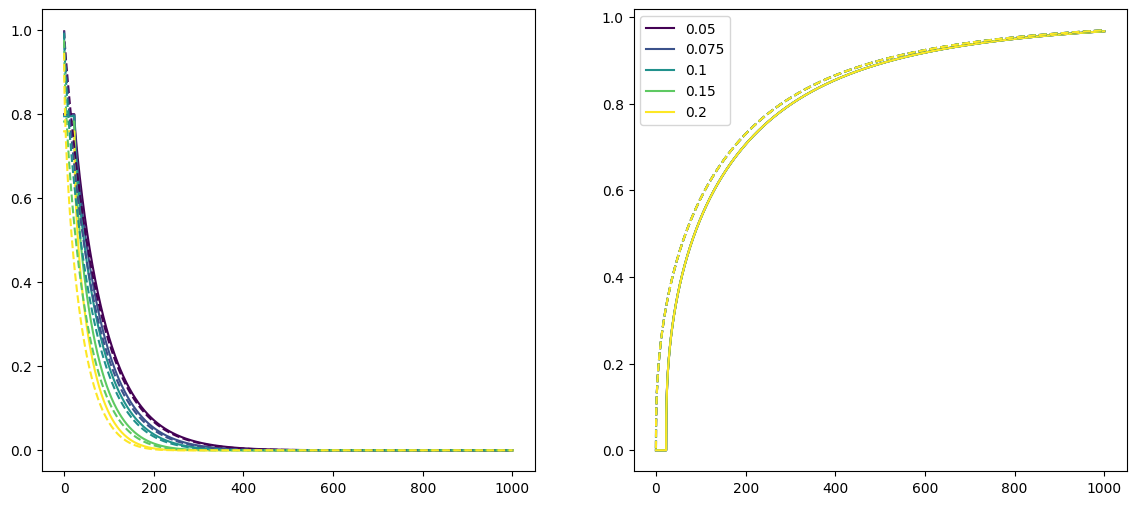

In [5]:
import matplotlib.pyplot as plt

# Define the stress factors and assign specific colors to each
stress_facs = [0.05, 0.075, 0.1, 0.15, 0.2]
colors = plt.cm.viridis([0, 0.25, 0.5, 0.75, 1])  # Generate a color map with 5 colors

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

temp = 0.8

# Plot with temp = 0.85
for s, color in zip(stress_facs, colors):
    normed = model.survival_curve / model.cfg.survival_max / temp
    stress = survival_to_stress(normed)
    back = stress_to_survival(stress + s) * temp
    
    ax[0].plot(model.concentration_curve, back, label=f'{s}', color=color)
    ax[1].plot(model.concentration_curve, stress, label=f'{s}', color=color)

temp = 1

# Plot with temp = 1 (dashed lines)
for s, color in zip(stress_facs, colors):
    normed = model.survival_curve / model.cfg.survival_max / temp
    stress = survival_to_stress(normed)
    back = stress_to_survival(stress + s) * temp
    
    ax[0].plot(model.concentration_curve, back, linestyle='dashed', color=color)
    ax[1].plot(model.concentration_curve, stress, linestyle='dashed', color=color)

ax[1].legend()
plt.show()


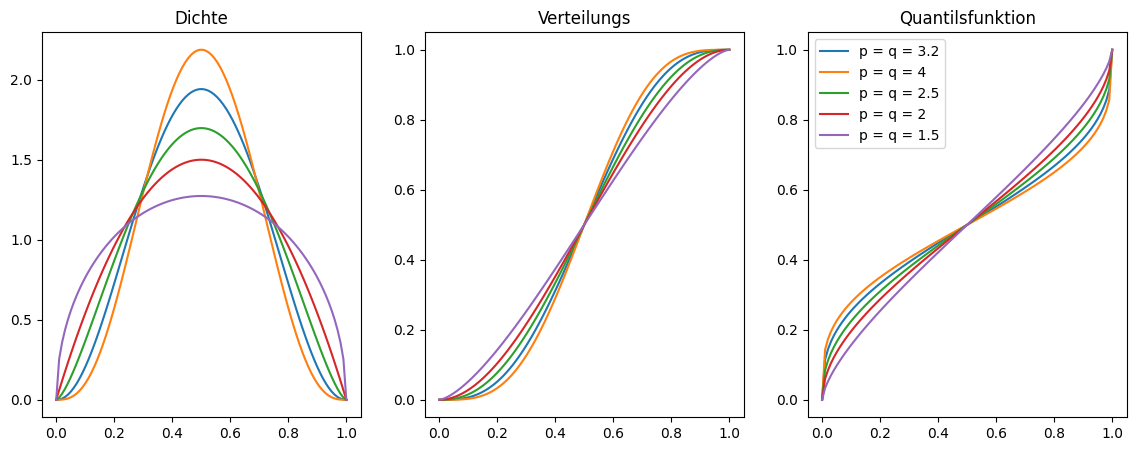

In [6]:
from scipy.stats import beta, norm


params = [3.2, 4, 2.5 , 2, 1.5]


p,q = 2.83 ,  3.17

# plot the distribution
plt.figure(figsize=(14, 5))
plt.subplot(131)
x = np.linspace(0, 1, 100)
for p in params:
    plt.plot(x, beta.pdf(x, p, p), label = f"p = q = {p}")
plt.title("Dichte")
plt.subplot(132)
# also cdf
for p in params:
    plt.plot(x, beta.cdf(x, p, p), label = f"p = q = {p}")
plt.title("Verteilungs")

plt.subplot(133)
# also cdf
for p in params:
    plt.plot(x, beta.ppf(x, p, p), label = f"p = q = {p}")
plt.title("Quantilsfunktion")
plt.legend()
plt.show()

In [55]:
import glob
from stress_addition_model import sam_prediction, Predicted_LCs, get_sam_lcs, SAM_Setting
from helpers import compute_lc, find_lc_99_max, compute_lc_from_curve
from plotting import plot_sam_prediction
from data_formats import ExperimentData, read_data
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from dataclasses import dataclass
from tqdm import tqdm
import time

In [67]:
@dataclass
class Prediction:
    data: ExperimentData
    main_fit: ModelPredictions
    stressor_fit: ModelPredictions
    best_stress: float
    best_pred: np.ndarray[np.float32]
    stressor_name: str
    best_r2 : float
    best_pred_r2 : np.ndarray

paths = glob.glob("data/*.xlsx")

settings = SAM_Setting(param_d_norm=False)

def compute()

results: list[Prediction] = []

for p in tqdm(paths):
    
    data = read_data(p)
    
    for name, val in data.additional_stress.items():

        main_series, stressor_series, meta = data.main_series, val, data.meta

        dose_cfg = StandardSettings(
            survival_max=meta.max_survival,
            beta_q=settings.beta_q,
            beta_p=settings.beta_p,
            param_d_norm=settings.param_d_norm,
        )

        main_fit = dose_response_fit(main_series, cfg=dose_cfg)


        stressor_fit = dose_response_fit(stressor_series, cfg=dose_cfg)


        goal = stressor_fit.survival_curve

        def mse(y, y_pred):
            return np.square(y - y_pred).sum(axis=-1)

        stresses = np.linspace(0, 0.7, 150)


        preds = stress_to_survival(stresses[:, None]  + main_fit.stress_curve[None,:], p = settings.beta_p, q = settings.beta_q)

        losses = mse(goal[None,], preds)

        best_stress_arg = np.argmin(losses)
        best_pred = preds[best_stress_arg]

        r2_losses = np.array([r2_score(goal, p) for p in preds])

        best_r2_stress_arg = np.argmax(r2_losses)

        results.append(
            Prediction(
                data=data,
                main_fit=main_fit,
                stressor_fit=stressor_fit,
                best_stress=stresses[best_stress_arg],
                best_pred=best_pred,
                stressor_name=name,
                best_r2=stresses[best_r2_stress_arg],
                best_pred_r2=preds[best_r2_stress_arg]
            )
        )



  0%|          | 0/15 [00:00<?, ?it/s]

Best stress level: 0.0
Best stress level: 0.07046979865771812
Best stress level: 0.08456375838926174
Best stress level: 0.15973154362416106
Best stress level: 0.2677852348993288
Best stress level: 0.33825503355704695


 13%|█▎        | 2/15 [00:05<00:38,  2.93s/it]

Best stress level: 0.39463087248322143
Best stress level: 0.0


 20%|██        | 3/15 [00:07<00:28,  2.34s/it]

Best stress level: 0.0
Best stress level: 0.0
Best stress level: 0.0


 33%|███▎      | 5/15 [00:09<00:17,  1.72s/it]

Best stress level: 0.0
Best stress level: 0.0
Best stress level: 0.0


 40%|████      | 6/15 [00:12<00:17,  1.96s/it]

Best stress level: 0.0
Best stress level: 0.0


 47%|████▋     | 7/15 [00:13<00:14,  1.82s/it]

Best stress level: 0.0
Best stress level: 0.0


 53%|█████▎    | 8/15 [00:15<00:11,  1.71s/it]

Best stress level: 0.0
Best stress level: 0.0
Best stress level: 0.0
Best stress level: 0.0
Best stress level: 0.0
Best stress level: 0.0
Best stress level: 0.0
Best stress level: 0.0


 67%|██████▋   | 10/15 [00:21<00:11,  2.31s/it]

Best stress level: 0.0
Best stress level: 0.0
Best stress level: 0.0
Best stress level: 0.0


 73%|███████▎  | 11/15 [00:24<00:10,  2.56s/it]

Best stress level: 0.0
Best stress level: 0.0


 80%|████████  | 12/15 [00:26<00:06,  2.29s/it]

Best stress level: 0.0
Best stress level: 0.0
Best stress level: 0.0
Best stress level: 0.0
Best stress level: 0.0
Best stress level: 0.0
Best stress level: 0.0
Best stress level: 0.0


 87%|████████▋ | 13/15 [00:31<00:06,  3.22s/it]

Best stress level: 0.0


100%|██████████| 15/15 [00:32<00:00,  2.19s/it]

Best stress level: 0.0


In [62]:

goal = stressor_fit.survival_curve

def get_pred(stress):
    return stress_to_survival(main_fit.stress_curve + stress) * meta.max_survival

ar = stresses[:, None]  + main_fit.stress_curve[None,:]

array([[0.97977339, 0.97977333, 0.97977327, ..., 0.04117711, 0.0411224 ,
        0.04106776],
       [0.97778459, 0.97778453, 0.97778446, ..., 0.03825784, 0.0382055 ,
        0.03815322],
       [0.97567861, 0.97567854, 0.97567847, ..., 0.03546674, 0.03541673,
        0.03536679],
       ...,
       [0.02998915, 0.02998907, 0.029989  , ..., 0.        , 0.        ,
        0.        ],
       [0.02758775, 0.02758768, 0.0275876 , ..., 0.        , 0.        ,
        0.        ],
       [0.02530827, 0.0253082 , 0.02530813, ..., 0.        , 0.        ,
        0.        ]])

In [64]:
%%timeit
stress_to_survival(ar)

483 ms ± 8.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


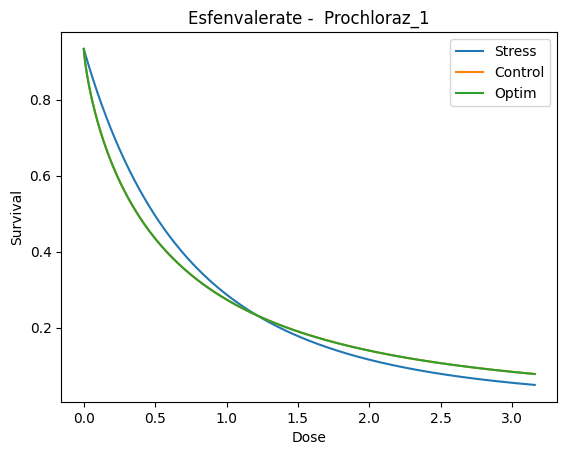

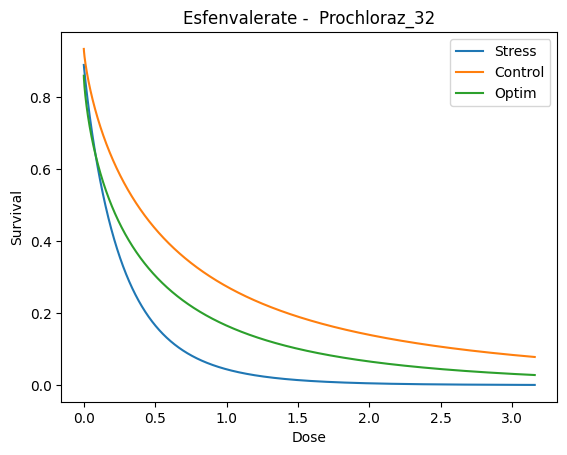

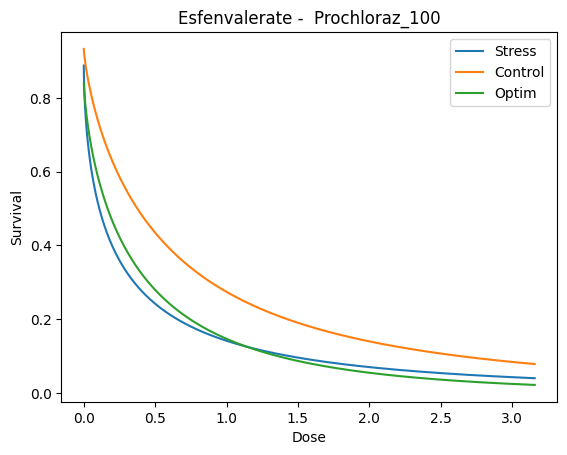

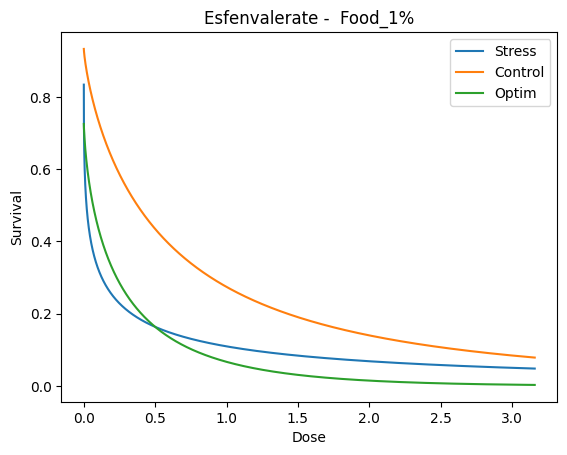

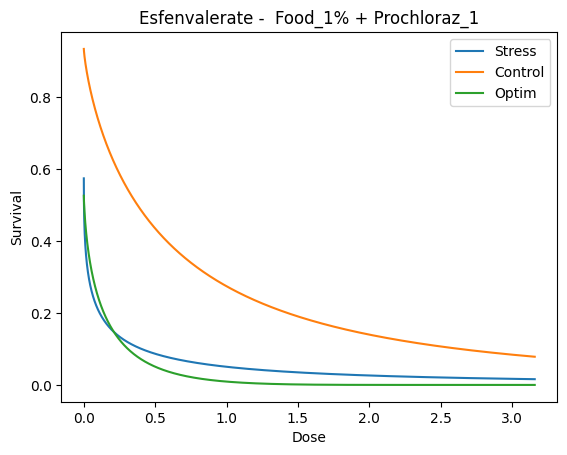

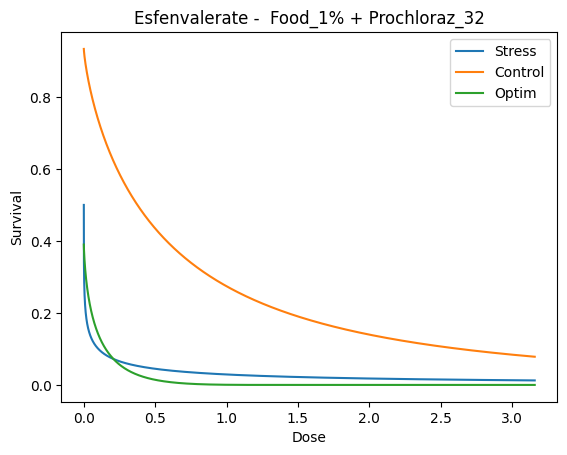

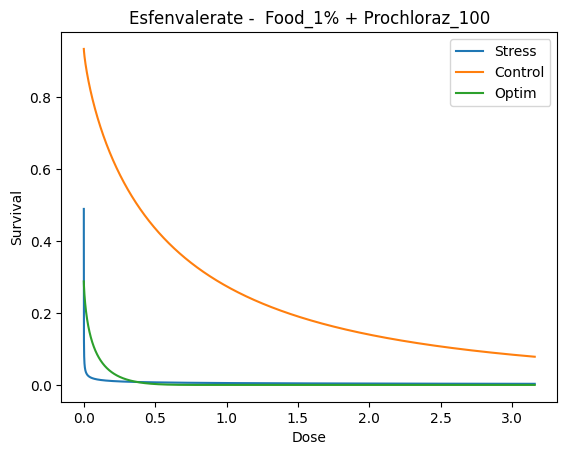

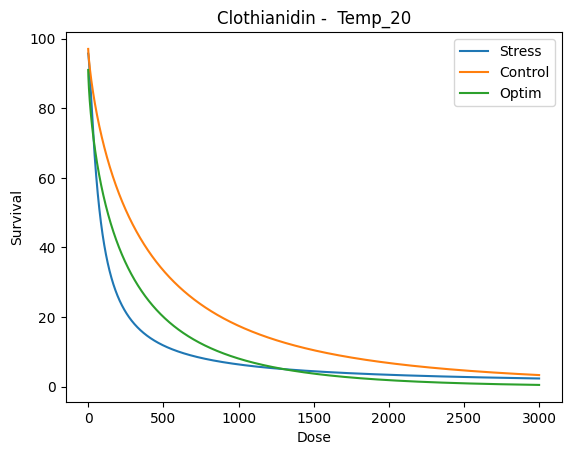

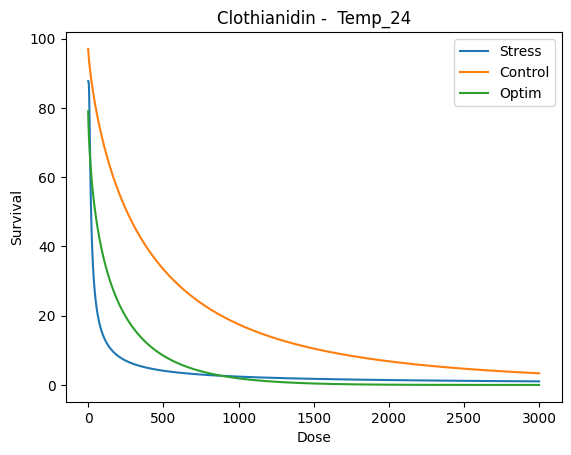

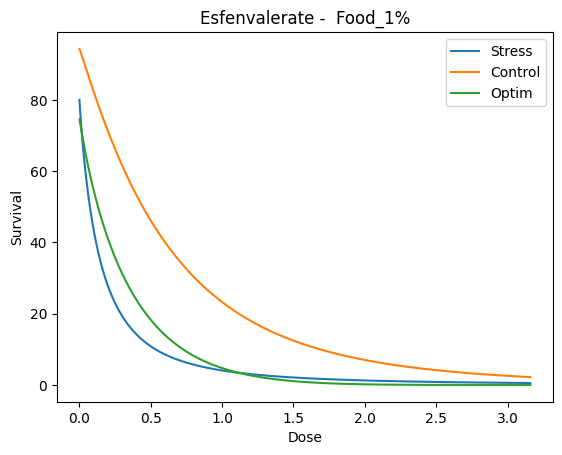

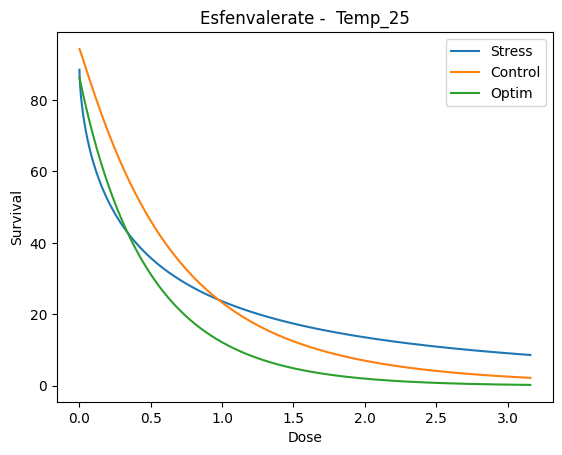

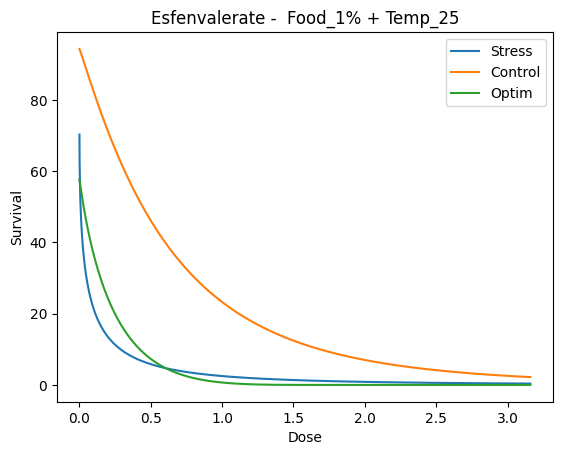

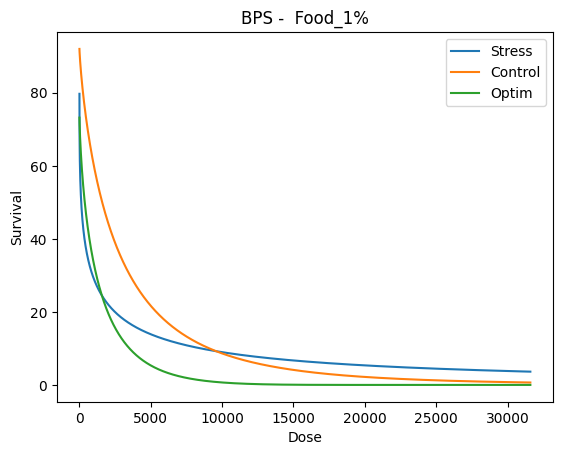

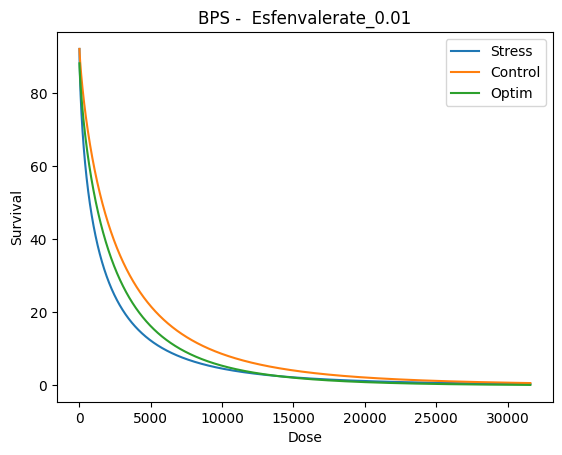

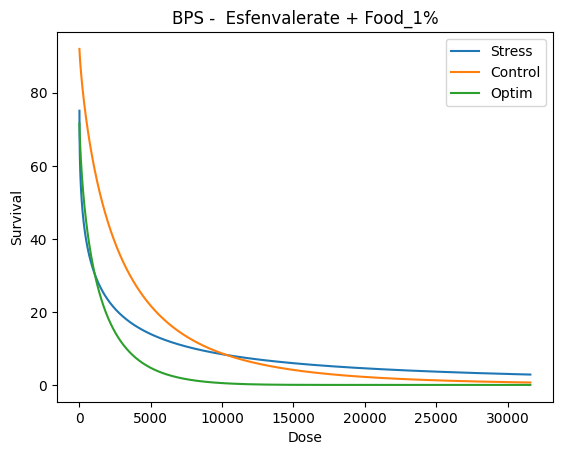

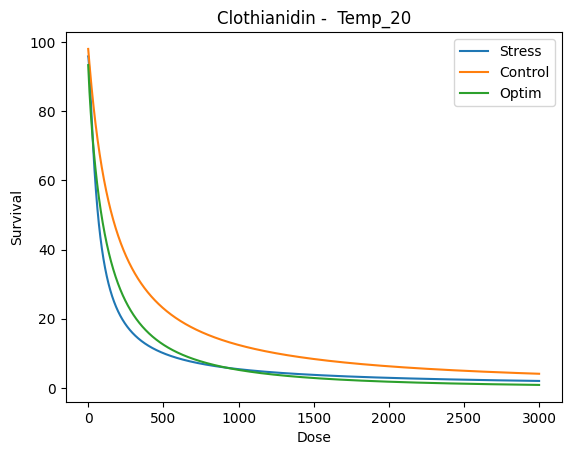

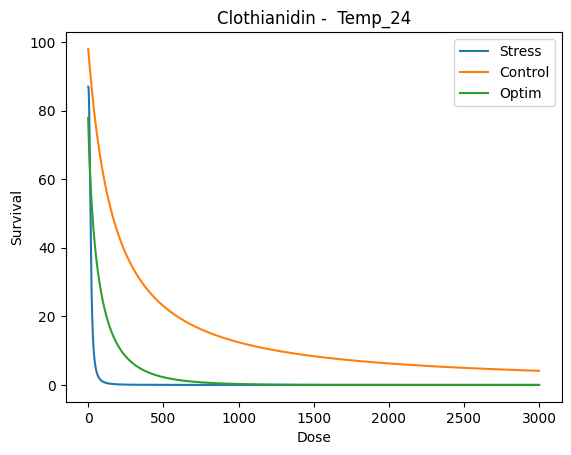

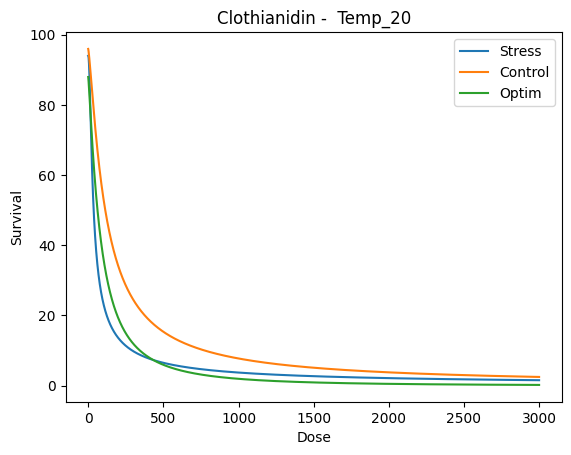

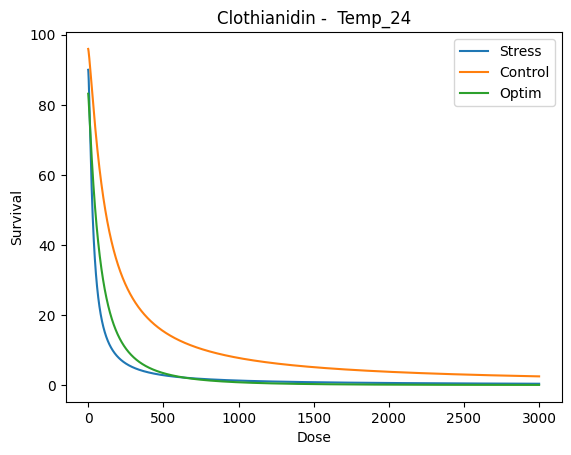

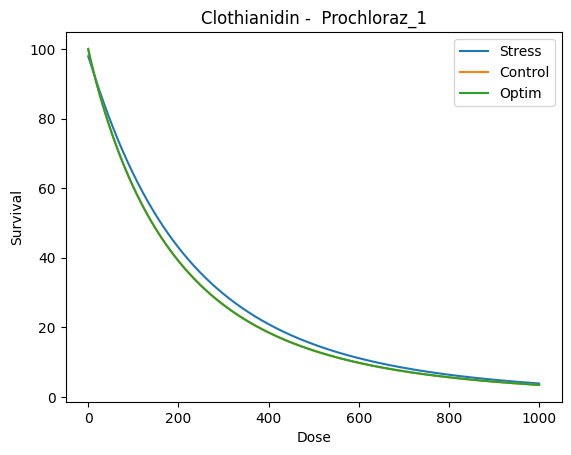

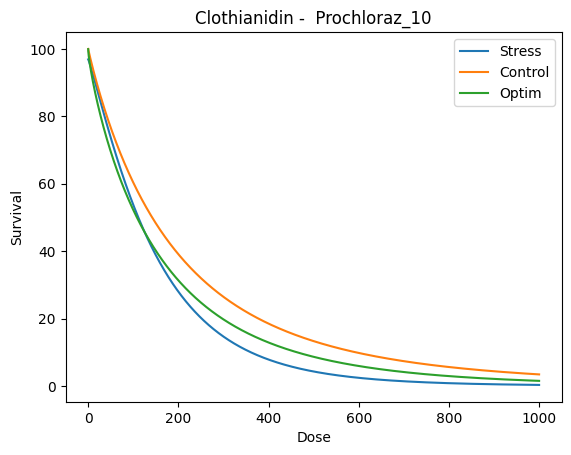

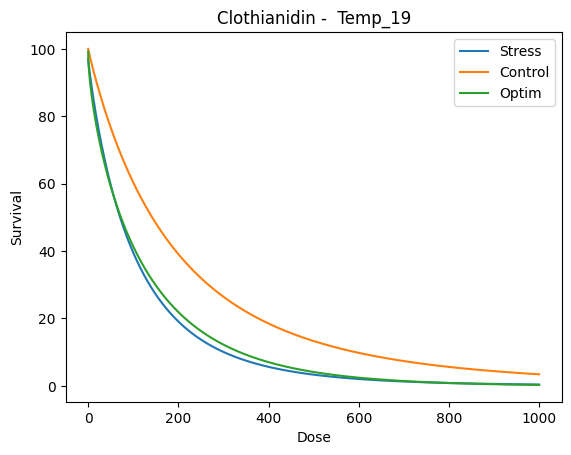

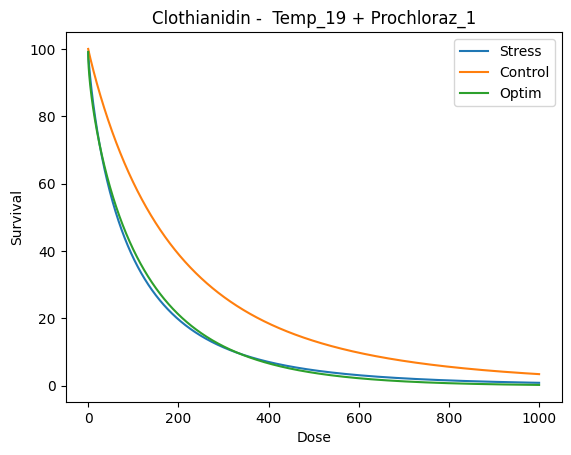

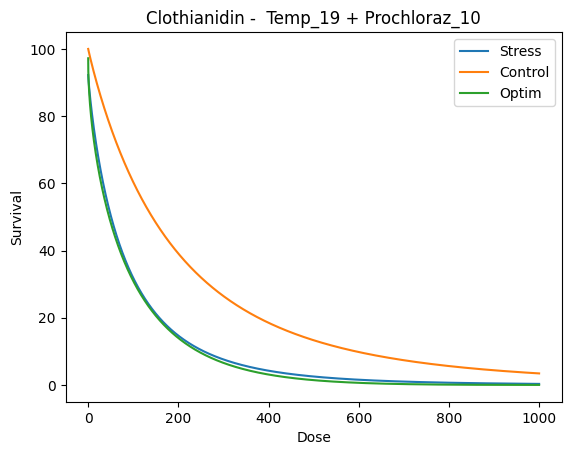

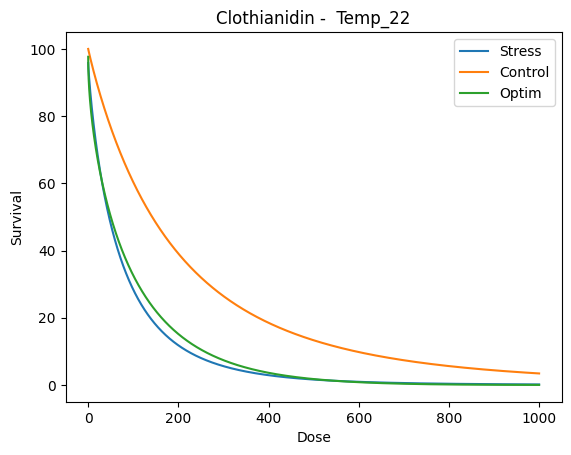

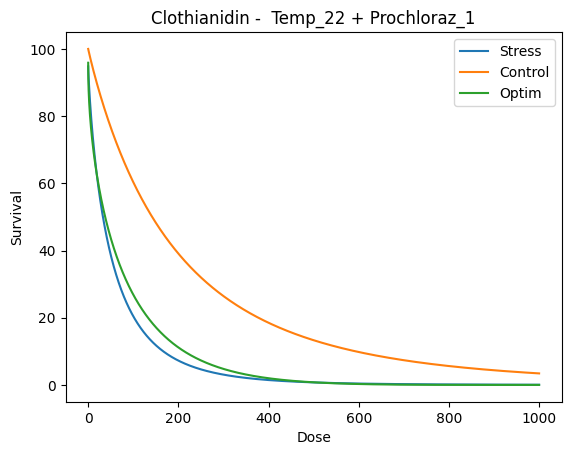

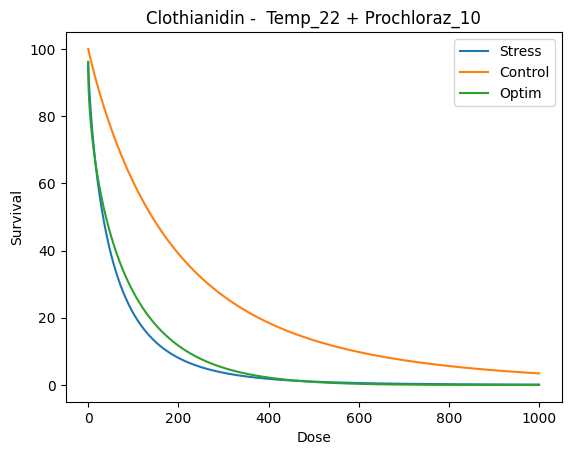

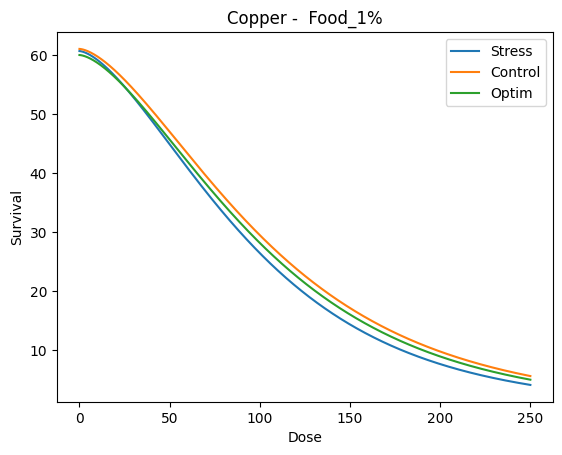

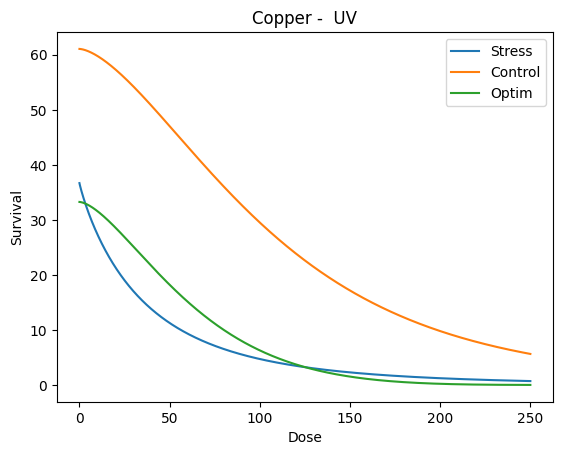

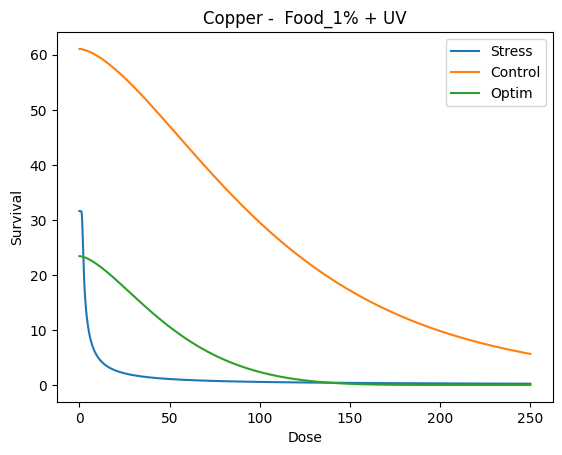

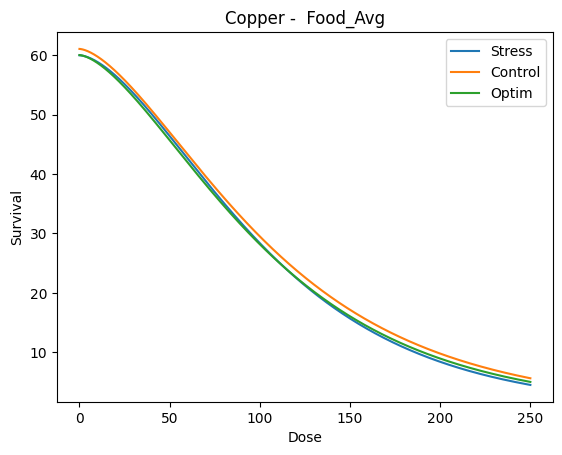

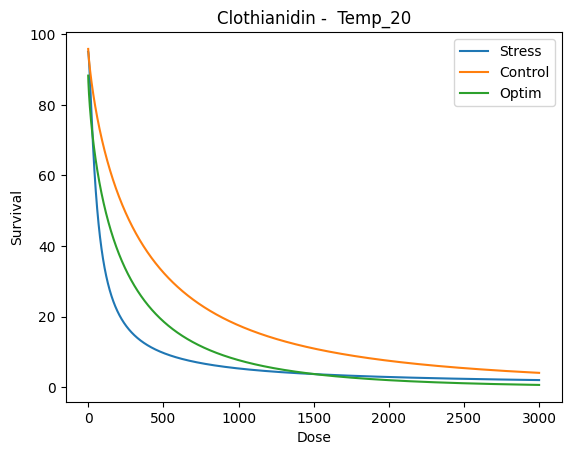

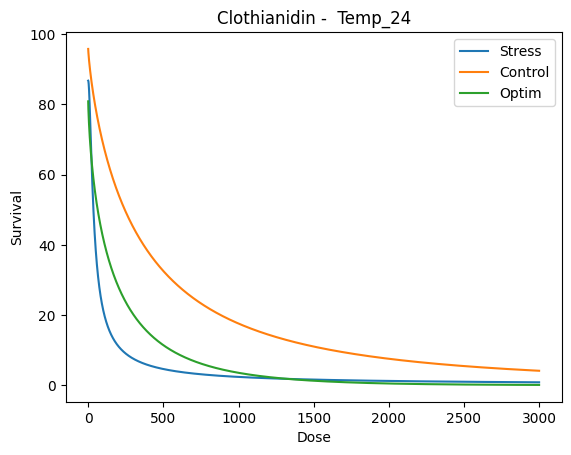

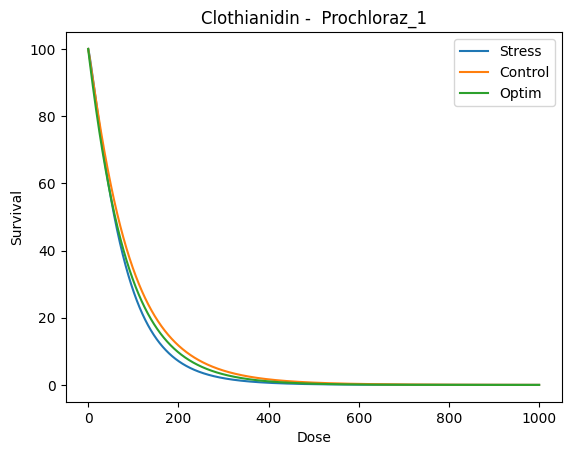

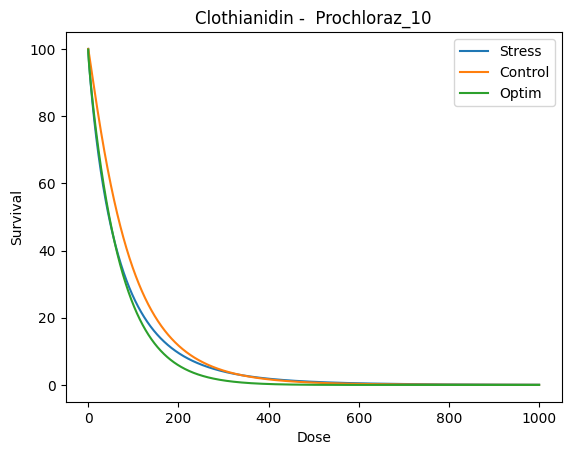

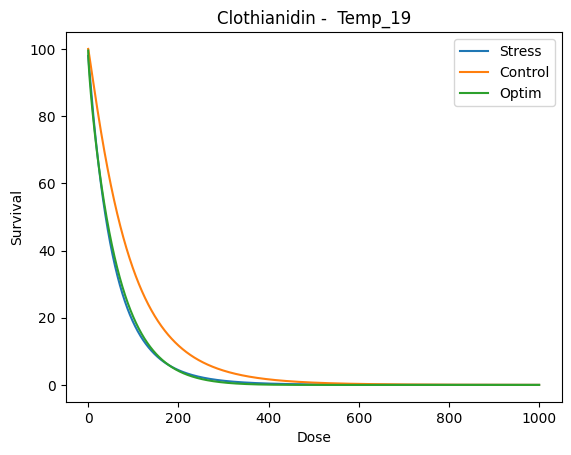

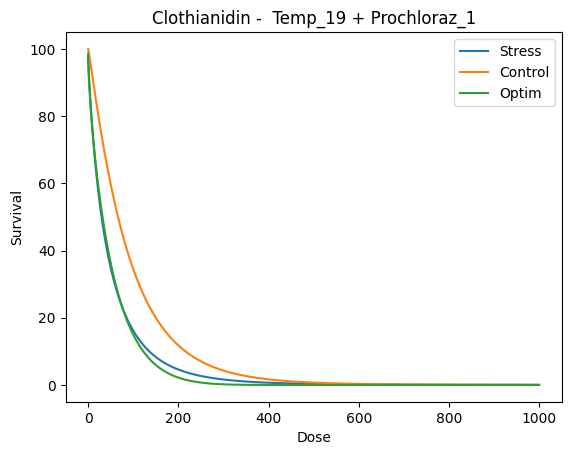

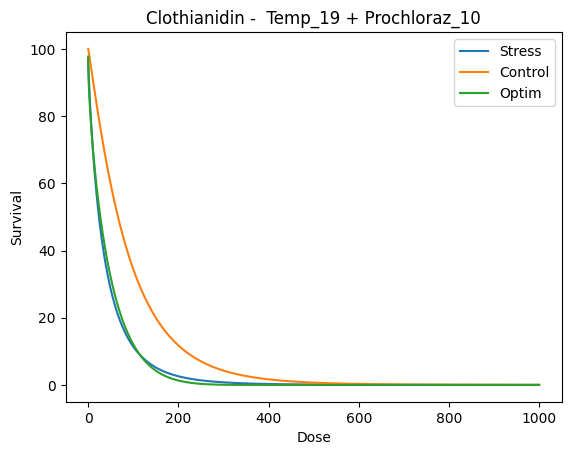

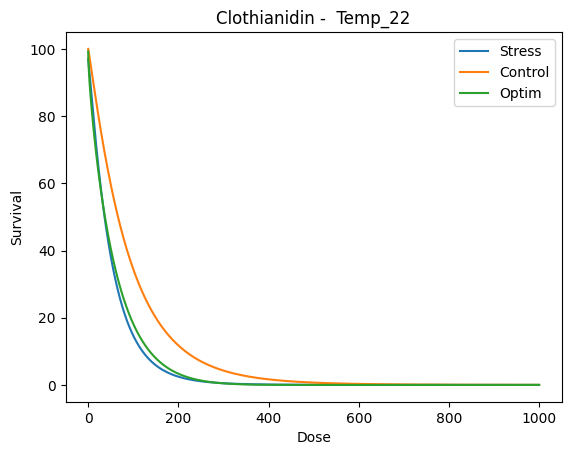

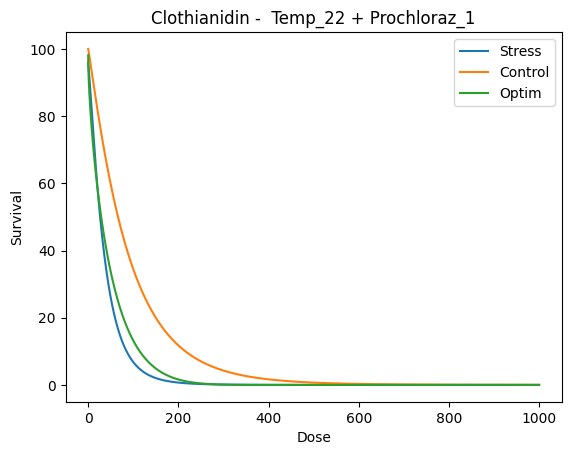

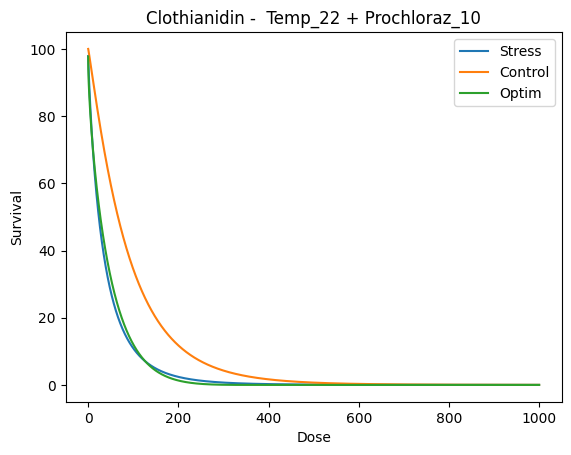

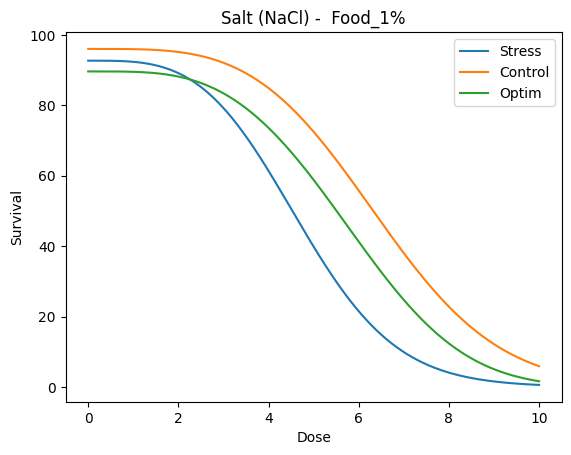

In [9]:
def plot_pred(pred: Prediction):

    x = pred.main_fit.concentration_curve

    plt.title(f"{pred.data.meta.chemical} -  {pred.stressor_name}")
    plt.plot(x, pred.stressor_fit.survival_curve, label="Stress")
    plt.plot(x, pred.main_fit.survival_curve, label="Control")
    plt.plot(x, pred.best_pred, label="Optim")
    # plt.plot(x, pred.best_pred_r2, label="r2")
    plt.ylabel("Survival")
    plt.xlabel("Dose")
    plt.legend()
    plt.show()
    
for r in results:
    
    plot_pred(r)

In [28]:
df = pd.DataFrame({
    "d_main" : [r.main_fit.optim_param["d"] for r in results],
    "d_stress" : [r.stressor_fit.optim_param["d"] for r in results],
    "best" : [r.best_stress for r in results],
    "best_r2" : [r.best_r2 for r in results],
    "path" : [r.data.meta.path for r in results],
    "stress" : [r.stressor_name for r in results],
    "chemical" : [r.data.meta.chemical for r in results],
})

df

,d_main,d_stress,best,best_r2,path,stress,chemical
0,0.933333,0.933333,0.000000,0.000000,data/naeem_Esfenvalerate_2019.xlsx,Prochloraz_1,Esfenvalerate
1,0.933333,0.888889,0.070470,0.070470,data/naeem_Esfenvalerate_2019.xlsx,Prochloraz_32,Esfenvalerate
2,0.933333,0.888889,0.084564,0.084564,data/naeem_Esfenvalerate_2019.xlsx,Prochloraz_100,Esfenvalerate
3,0.933333,0.844444,0.159732,0.159732,data/naeem_Esfenvalerate_2019.xlsx,Food_1%,Esfenvalerate
4,0.933333,0.577778,0.267785,0.267785,data/naeem_Esfenvalerate_2019.xlsx,Food_1% + Prochloraz_1,Esfenvalerate
5,0.933333,0.533333,0.338255,0.338255,data/naeem_Esfenvalerate_2019.xlsx,Food_1% + Prochloraz_32,Esfenvalerate
6,0.933333,0.488889,0.394631,0.394631,data/naeem_Esfenvalerate_2019.xlsx,Food_1% + Prochloraz_100,Esfenvalerate
7,0.970530,0.957080,0.079866,0.079866,data/ayesha-cloth_Clothianidin_2024_agricultur...,Temp_20,Clothianidin
8,0.970530,0.877680,0.173826,0.173826,data/ayesha-cloth_Clothianidin_2024_agricultur...,Temp_24,Clothianidin
9,0.942857,0.800000,0.159732,0.159732,data/naeem_Esfenvalerate_2024.xlsx,Food_1%,Esfenvalerate


In [29]:
mask = np.logical_or(df.d_main <= df.d_stress ,  df.best == 0)
df.loc[mask]

,d_main,d_stress,best,best_r2,path,stress,chemical
0,0.933333,0.933333,0.000000,0.000000,data/naeem_Esfenvalerate_2019.xlsx,Prochloraz_1,Esfenvalerate
13,0.920000,0.920000,0.037584,0.037584,data/bps_esf_food_2024.xlsx,Esfenvalerate_0.01,BPS
19,1.000000,0.979000,0.000000,0.000000,data/naemm_Clothianidin_2024_agricultural.xlsx,Prochloraz_1,Clothianidin
33,1.000000,1.000000,0.018792,0.018792,data/naemm_Clothianidin_2024_reference.xlsx,Prochloraz_1,Clothianidin
34,1.000000,1.000000,0.061074,0.061074,data/naemm_Clothianidin_2024_reference.xlsx,Prochloraz_10,Clothianidin


In [30]:
df = df.loc[~mask]

$$\text{Toxicant Stress} = \text{survival\_to\_stress}(\text{Toxicant}) - \text{survival\_to\_stress}(\text{Control})$$
$$\text{Toxicant Stress} =
\text{Beta}^{-1}(1 - \text{Toxicant}) - \text{Beta}^{-1}(1 - \text{Control})$$

/tmp/ipykernel_11376/1511274486.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"] = pred


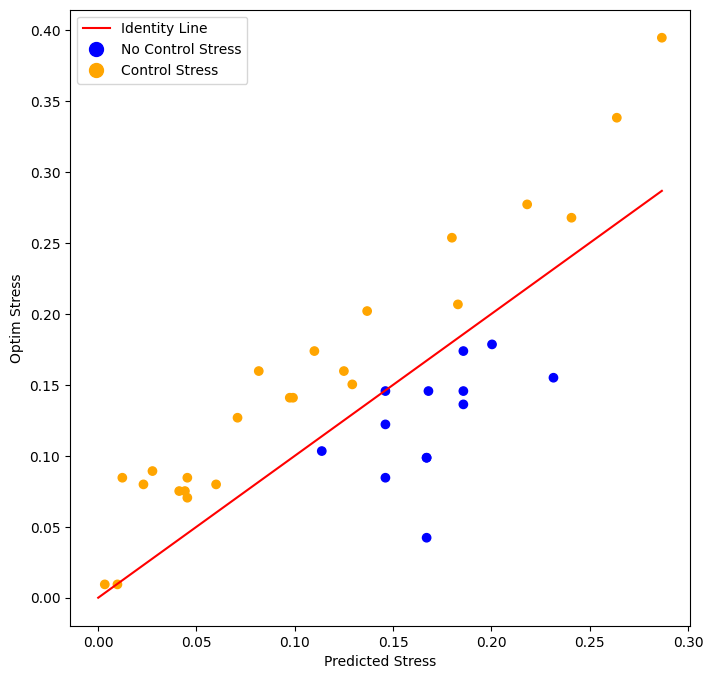

In [31]:
import matplotlib.lines as mlines

pred = survival_to_stress(df.d_stress) - survival_to_stress(df.d_main)
df["pred"] = pred

colors = ["orange" if q < 1 else "blue" for q in df.d_main]

plt.figure(figsize=(8,8))
plt.scatter(df['pred'], df['best'], c=colors, label='Data Points')

# Plot the identity line
x = np.linspace(0, df['pred'].max(), 30)
y_line = x
plt.plot(x, y_line, c="red", label='Identity Line')

# Labels
plt.xlabel("Predicted Stress")
plt.ylabel("Optim Stress")


identity_line = mlines.Line2D([], [], color='red', label='Identity Line')
no_control_stress = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=10, label='No Control Stress')
control_stress = mlines.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=10, label='Control Stress')

plt.legend(handles=[identity_line, no_control_stress, control_stress])
# Display the plot
plt.show()


In [54]:
survival_to_stress(0.9995, p = 3.4,q = 3.4)

np.float64(0.04821222048653489)

In [39]:
stress_to_survival(0.05)

np.float64(0.9991924615598251)

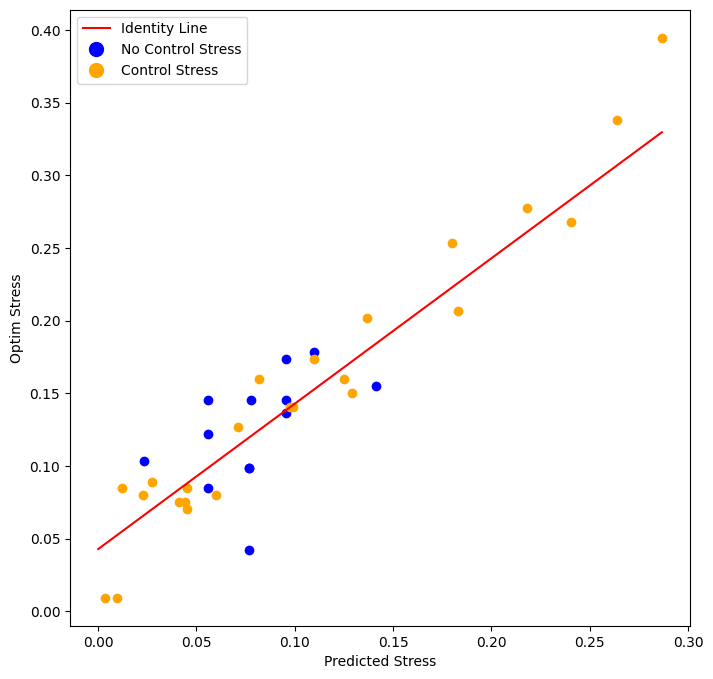

In [49]:
mask = df.d_main == 1
padding = df.loc[mask].copy()
padding.d_main = 0.995


pred = survival_to_stress(padding.d_stress) - survival_to_stress(padding.d_main)
padding["pred"] = pred


plt.figure(figsize=(8,8))
plt.scatter(padding['pred'], padding['best'], c = "blue")
plt.scatter(df.loc[~mask,'pred'], df.loc[~mask,'best'], c = "orange")

# Plot the identity line
x = np.linspace(0, df['pred'].max(), 30)
y_line = x + survival_to_stress(0.9995)
plt.plot(x, y_line, c="red", label='Identity Line')

identity_line = mlines.Line2D([], [], color='red', label='Identity Line')
no_control_stress = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=10, label='No Control Stress')
control_stress = mlines.Line2D([], [], color='orange', marker='o', linestyle='None', markersize=10, label='Control Stress')

plt.legend(handles=[identity_line, no_control_stress, control_stress])
# Display the plot
plt.xlabel("Predicted Stress")
plt.ylabel("Optim Stress")
plt.show()


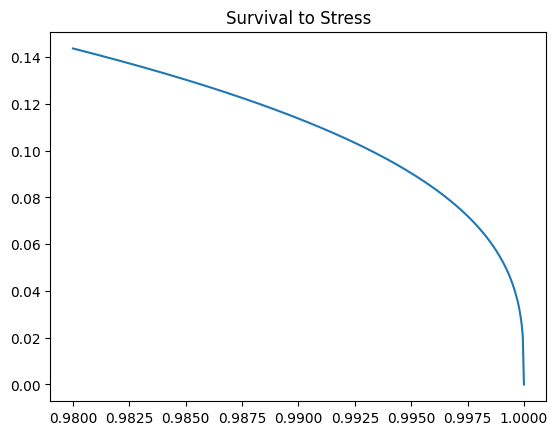

In [16]:
survival = np.linspace(1, 0.98, 400)
plt.plot(survival, survival_to_stress(survival))
plt.title("Survival to Stress")
plt.show()

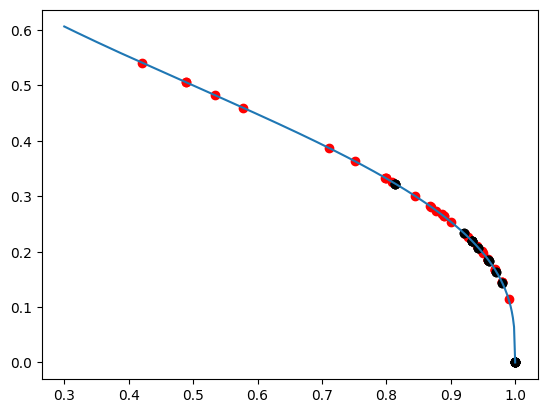

In [17]:
survival = np.linspace(1, 0.3, 400)
y = survival_to_stress(survival=survival)
plt.plot(survival, y)
x = df.loc[~mask].d_stress

plt.scatter(x, survival_to_stress(x), c= "red")

x = df.loc[~mask].d_main

plt.scatter(x, survival_to_stress(x), c= "black")

In [18]:
survival_to_stress(1)

np.float64(0.0)

In [19]:
survival_to_stress(0.95)

np.float64(0.1975601130544024)

In [20]:
df.loc[mask]

,d_main,d_stress,best,best_r2,path,stress,chemical,pred
